### Covariance analyses on Marius' V1 receptive field data
The receptive fields were calculated in response to white noise stimuli.

In [75]:
import os
import os.path as path

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import pickle
from scipy import stats
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.decomposition import PCA

from src.data.load_dataset import load_V1_whitenoise
from src.models.weights import V1_covariance_matrix, V1_weights

data_dir = path.abspath(path.join(os.getcwd(), "../../"))

#### Load data and select cells with snr > 0.4

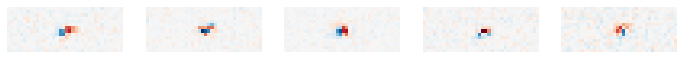

In [2]:
rf_data, snr, dim = load_V1_whitenoise(centered=True)
center = (int(dim[0] / 2), int(dim[1] / 2))
rf = rf_data[snr > 0.4]
num_cells = rf.shape[0]

# normalize for plotting
rf_norm = (rf - np.mean(rf, axis=1).reshape(-1, 1)) / np.std(rf, axis=1).reshape(-1, 1)
fig = plt.figure(figsize=(12, 5))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    i = np.random.randint(len(rf))
    cell_rf = rf_norm[i]
    plt.imshow(cell_rf.reshape(dim), cmap='RdBu')
    plt.clim(-10, 10)
    plt.axis('off')

#### Compute covariance from data and fit optimal hyperparameters

In [3]:
# compute data covariance
cov_data = rf.T @ rf
cov_data *= cov_data.shape[1] / np.trace(cov_data)

# find params that minimize frobenius norm difference between data and covariance model
def frob_norm_diff(x):
    cov_model = V1_covariance_matrix(dim, size=x[0], spatial_freq=x[1], center=center, scale=1)
    return la.norm(cov_data - cov_model)

x0 = [10, 2]
minimize_diff = minimize(frob_norm_diff, x0, method='BFGS', tol=1e-4)
size_min, freq_min = minimize_diff.x
print('Optimal params: s=%0.2f, f=%0.2f' % (size_min, freq_min))

Optimal params: s=1.87, f=0.70


#### Generate covariance matrices for data and model

(120.0, 420.0)

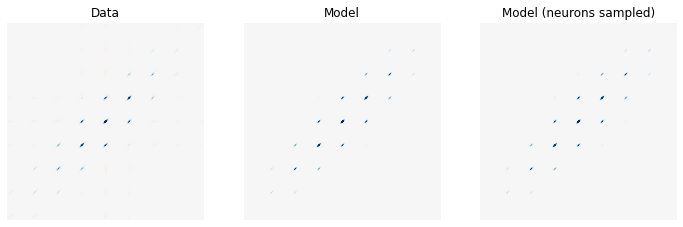

In [42]:
# model
cov_model = V1_covariance_matrix(dim, size_min, freq_min, center=center, scale=1)

# cov from sampled neurons
W = V1_weights(num_cells, dim, size_min, freq_min, center=center, scale=1)
cov_sampled_neurons = W.T @ W
cov_sampled_neurons *= cov_sampled_neurons.shape[0] / np.trace(cov_sampled_neurons)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(131)
plt.title('Data')
plt.imshow(cov_data, cmap='RdBu')
plt.clim(-8, 8)
plt.axis('off')
plt.xlim(120, 420)
plt.ylim(120, 420)

ax = fig.add_subplot(132)
plt.title('Model')
plt.imshow(cov_model, cmap='RdBu')
plt.clim(-8, 8)
plt.axis('off')
plt.xlim(120, 420)
plt.ylim(120, 420)

ax = fig.add_subplot(133)
plt.title('Model (neurons sampled)')
plt.imshow(cov_sampled_neurons, cmap='RdBu')
plt.clim(-8, 8)
plt.axis('off')
plt.xlim(120, 420)
plt.ylim(120, 420)
# plt.savefig('reports/figures/cov_mat_fitted_Marius_whitenoise.pdf')

#### plot some receptive fields

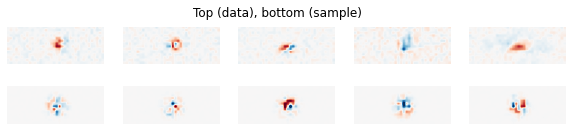

In [5]:
fig = plt.figure(figsize=(10, 2))
plt.suptitle('Top (data), bottom (sample)')
for i in range(5):
    idx = np.random.randint(num_cells)
    ax = fig.add_subplot(2, 5, i + 1)
    cell_rf = rf_norm[idx].reshape(dim) 
    plt.imshow(cell_rf, cmap='RdBu')
    plt.clim([-10, 10])
    plt.axis('off')
    
    
    ax = fig.add_subplot(2, 5, 5 + i + 1)
    cell_rf = W[idx].reshape(dim) 
    plt.imshow(cell_rf, cmap='RdBu')
    plt.clim([-8, 8])
    plt.axis('off')
# plt.savefig('reports/figures/receptive_fields_Marius_whitenoise.pdf')

#### generate covariance with fine discretization for spectral analysis

In [6]:
# plot the V1 covariance matrix with finer mesh
size, freq, scale = size_min.copy(), freq_min.copy(), 1

x = np.arange(0, dim[0], 0.5)
y = np.arange(0, dim[1], 0.5)
yy, xx = np.meshgrid(y, x)
grid = np.column_stack((xx.flatten(), yy.flatten()))

a = squareform(pdist(grid, 'sqeuclidean'))
b = la.norm(grid - center, axis=1) ** 2
c = b.reshape(-1, 1)
cov_model_fine = np.exp(-a / (2 * freq ** 2)) * np.exp(-b / (2 * size ** 2)) * np.exp(-c / (2 * size ** 2))
cov_model_fine += 1e-5 * np.eye(len(cov_model_fine))
cov_model_fine *= (scale * cov_model_fine.shape[0] / np.trace(cov_model_fine))

# generate weights
W_fine = np.random.multivariate_normal(np.zeros(cov_model_fine.shape[0]), cov_model_fine, num_cells)
cov_sampled_neurons_fine = W_fine.T @ W_fine
cov_sampled_neurons_fine *= (cov_sampled_neurons_fine.shape[0] / np.trace(cov_sampled_neurons_fine))

#### Compute eigenvalues and eigenvectors

In [59]:
# generate eigenfunctions and eigenvalues from the covariance matrices
eval_data, evec_data = la.eigh(cov_data)
eval_model, evec_model = la.eigh(cov_model)
eval_sampled_neurons, evec_sampled_neurons = la.eigh(cov_sampled_neurons)

#### define the analytical form of the eigenfunctions and eigenvalues

In [71]:
from scipy.special import eval_hermitenorm
def phi(x, s, f, k):
    ''' Orthonormal eigenfunctions of the V1 kernel in 1d'''
    alpha, beta = 1 / (2 * f ** 2), 1 / (2 * s ** 2)
    D = np.sqrt(beta ** 2 + 2 * alpha * beta)
    C = np.sqrt(2 * D)
    normalization_fac = 2 ** k * np.math.factorial(k) * np.sqrt(np.pi) / C
    return np.exp(- D * x ** 2) * eval_hermitenorm(k, C * x)

def lamda(s, f, k):
    ''' Eigenvalues of the V1 kernel in 1d '''
    alpha, beta = 1 / (2 * f ** 2), 1 / (2 * s ** 2)
    D = np.sqrt(beta ** 2 + 2 * alpha * beta)
    C = np.sqrt(2 * D)
    X = alpha + beta + D
    return np.sqrt(np.pi / X) * ( 1 - C ** 2 / X) ** (k / 2)


# generate all the eigenfunctions 
x = np.arange(-center[0], center[0], 0.1)
y = np.arange(-center[1], center[1], 0.1)
yy, xx = np.meshgrid(y, x)

evec_anal = np.empty((0, len(x) * len(y)))
eval_anal = np.empty((0, ))
for k1 in range(15):
    for k2 in range(15):
        eigvec = phi(yy, size_min, freq_min, k1) * phi(xx, size_min, freq_min, k2)
        eigvec = eigvec.reshape(1, -1)
        eigval = lamda(size_min, freq_min, k1) * lamda(size_min, freq_min, k2)
        
        evec_anal = np.append(evec_anal, eigvec.reshape(1, -1), axis=0)
        eval_anal = np.append(eval_anal, eigval)
        
# sort in descending order
idx = np.argsort(-eval_anal)
evec_anal = evec_anal[idx]
eval_anal = eval_anal[idx[::-1]]

#### Plot eigenvalues from all 4 (data, model, sampled neurons, analytical)

Data: 100 evecs explain 0.87 variance
Model: 100 evecs explain 1.00 variance
Sampled neurons: 100 evecs explain 1.00 variance


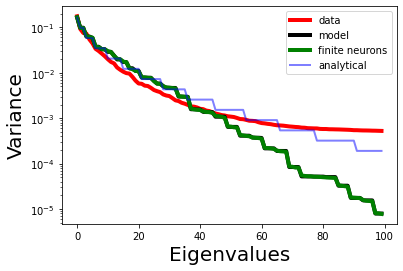

In [72]:
# eigevalues
eval_data /= np.sum(eval_data)
eval_model /= np.sum(eval_model)
eval_sampled_neurons /= np.sum(eval_sampled_neurons)
eval_anal /= np.sum(eval_anal)

t = 100
fig = plt.figure()
plt.semilogy(np.flip(eval_data)[:t], lw=4, c='r', label='data')
plt.semilogy(np.flip(eval_model)[:t], lw=4, c='k', label='model')
plt.semilogy(np.flip(eval_sampled_neurons)[:t], lw=4, c='g', label='finite neurons')
plt.semilogy(np.flip(eval_anal)[:t], lw=2, c='b', alpha=0.5, label='analytical')
plt.legend()
# plt.ylim(1e-4, 1e-1)
plt.xlabel('Eigenvalues', fontsize=20)
plt.ylabel('Variance', fontsize=20)

print('Data: %d evecs explain %0.2f variance' % (t, np.sum(eval_data[-t:])))
print('Model: %d evecs explain %0.2f variance' % (t, np.sum(eval_model[-t:])))
print('Sampled neurons: %d evecs explain %0.2f variance' % (t, np.sum(eval_sampled_neurons[-t:])))
# plt.savefig('reports/figures/cov_mat_eigvals_Marius_whitenoise.pdf')

#### Plot eigenfunctions from all 4 (data, model, sampled neurons, analytical)

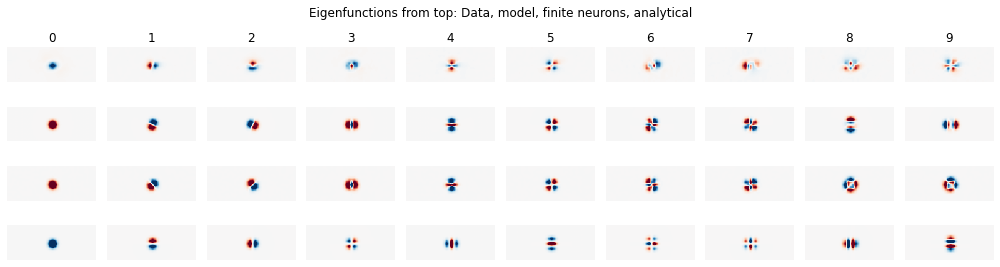

In [70]:
# plot eigenfunctions from all 4 (data, model, finite sample, analytical)
fig = plt.figure(figsize=(14, 4))
plt.suptitle('Eigenfunctions from top: Data, model, finite neurons, analytical')
for i in range(10):
    ax = fig.add_subplot(4, 10, i + 1)
    plt.imshow(evec_data[:, - i-1].reshape(dim), cmap='RdBu')
    plt.title(i)
    plt.clim(-0.4, 0.4)
    plt.axis('off')
    
    ax = fig.add_subplot(4, 10, 10 + i + 1)
    plt.imshow(evec_model[:, -i-1].reshape(dim[0] * 1, dim[1] * 1), cmap='RdBu')
    plt.clim(-0.2, 0.2)
    plt.axis('off')
    
    ax = fig.add_subplot(4, 10, 20 + i + 1)
    plt.imshow(evec_sampled_neurons[:,  - i - 1].reshape(dim[0] * 1, dim[1] * 1), cmap='RdBu')
    plt.clim(-0.2, 0.2)
    plt.axis('off')
    
    ax = fig.add_subplot(4, 10, 30 + i + 1)
    plt.imshow(evec_anal[i].reshape(dim[0] * 10, dim[1] * 10), cmap='RdBu')
    plt.clim(-0.3, 0.3)
    plt.axis('off')
    
plt.tight_layout()
plt.subplots_adjust(top=0.9)
# plt.savefig('reports/figures/cov_mat_eigvecs_Marius_whitenoise.pdf')

In [77]:
## save results
covariance = {'data': cov_data, 'model': cov_model, 'finite': cov_sampled_neurons}
eig_vecs = {'data': evec_data, 'model': evec_model, 'finite': evec_sampled_neurons, 'analytical': evec_anal}
eig_vals = {'data': eval_data, 'model': eval_model, 'finite': eval_sampled_neurons, 'analytical': eval_anal}
results = {'covariance': covariance, 'evecs': eig_vecs, 'evals': eig_vals}

with open(data_dir + '/models/results/covariance_analysis/v1_wn_covariance.pickle', 'wb') as file:
    pickle.dump(results, file)

### Use normality tests and qq-plot to check whether the data is normal

In [23]:
# whiten the dataset
rf = (rf - np.mean(rf, axis=0)) / np.std(rf, axis=0)
pca = PCA(whiten=True)
rf = pca.fit_transform(rf)

# calculate the mahalanobis distance for every point
mean = np.mean(rf, axis=0).reshape(1, -1)
dist = cdist(rf, mean, 'mahalanobis') ** 2

# calculate the theoretical quantiles w.r.t. chi squared distribution
(theoretical_q, empirical_q), (slope, intercept, r) = stats.probplot(dist.flatten(), dist=stats.chi2, sparams=dim[0] * dim[1])
t = np.arange(np.min(theoretical_q), np.max(theoretical_q), 0.5)
y = slope * t + intercept # best fit line

# calculate the cdf and pdf of real data
pdf_data, bins_data = np.histogram(dist, bins=100, density=True)
bin_size_data = bins_data[1] - bins_data[0]
cdf_data = np.cumsum(pdf_data * bin_size_data)

# calculate the cdf and pdf of chi squared distribution
chi_rv = stats.chi2.rvs(dim[0] * dim[1], size=rf.shape)
pdf_chi, bins_chi = np.histogram(chi_rv, bins=100, density=True)
bin_size_chi = bins_chi[1] - bins_chi[0]
cdf_chi = np.cumsum(pdf_chi * bin_size_chi)

/opt/anaconda3/envs/random_features/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Wilkes-Shapiro test: ws statistic: 1.00, p-value 1.00. Data is normal? True


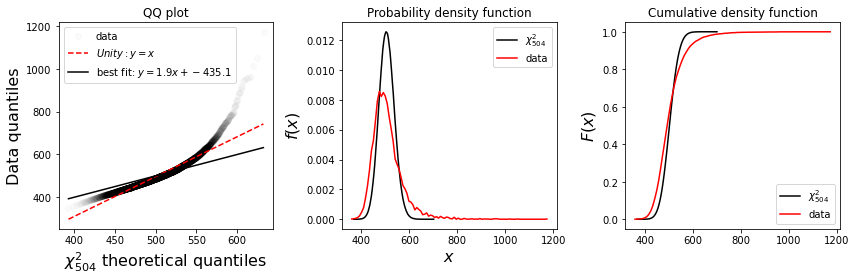

In [24]:
# perform the WS test
ws, pval = stats.shapiro(rf)
normal = True if pval > 0.05 else False 
print('Wilkes-Shapiro test: ws statistic: {:.2f}, p-value {:.2f}. Data is normal? {}'.format(ws, pval, normal))

fig = plt.figure(figsize=(12, 4))
# plot the qq-plot
ax = fig.add_subplot(131)
plt.title('QQ plot')
plt.plot(theoretical_q, empirical_q, 'ko', alpha=0.02, label='data')
plt.plot(t, y, 'r--', label=r'$Unity: y=x$')
plt.plot(t, t, 'k-', label=r'best fit: $y={:.1f}x + {:.1f}$'.format(slope, intercept))
plt.legend()
plt.xlabel(r'$\chi^2_{%d}$ theoretical quantiles' % (dim[0] * dim[1]), fontsize=16)
plt.ylabel('Data quantiles', fontsize=16)

# plot pdf
ax = fig.add_subplot(132)
plt.title('Probability density function')
plt.plot(bins_chi[1:], pdf_chi, 'k-', label=r'$\chi^2_{%d}$' % (dim[0] * dim[1]))
plt.plot(bins_data[1:], pdf_data, 'r-', label='data')
plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$f(x)$', fontsize=16)
plt.legend()

# plot cdf
ax = fig.add_subplot(133)
plt.title('Cumulative density function')
plt.plot(bins_chi[1:], cdf_chi, 'k-', label=r'$\chi^2_{%d}$' % (dim[0] * dim[1]))
plt.plot(bins_data[1:], cdf_data, 'r-', label='data')
plt.ylabel(r'$x$', fontsize=16)
plt.ylabel(r'$F(x)$', fontsize=16)
plt.legend()

plt.tight_layout()
# plt.savefig('reports/figures/normality_tests/qq_plot_Marius_whitenoise.pdf')